In [10]:
import numpy as np
import pandas as pd
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("bmh")
plt.rcParams['font.family'] = 'DejaVu Sans'
import scipy.stats as ss
from scipy.stats import norminvgauss

from arch import arch_model 
import yfinance as yf

In [11]:
import yfinance as yf
start_date='2018-07-01'
end_date='2022-06-30'
Amazon_data = yf.download('AMZN', start=start_date, end=end_date)
Amazon_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-07-02,84.135002,85.694504,83.903000,85.689003,85.689003,63714000
2018-07-03,86.197998,86.250000,84.624001,84.697998,84.697998,43546000
2018-07-05,85.268997,85.534500,84.107498,84.986504,84.986504,59662000
2018-07-06,84.800003,85.763496,84.583504,85.531502,85.531502,53006000
2018-07-09,86.202499,86.977997,85.811501,86.950996,86.950996,60240000


### Графики цены закрытия и скорректированной цены

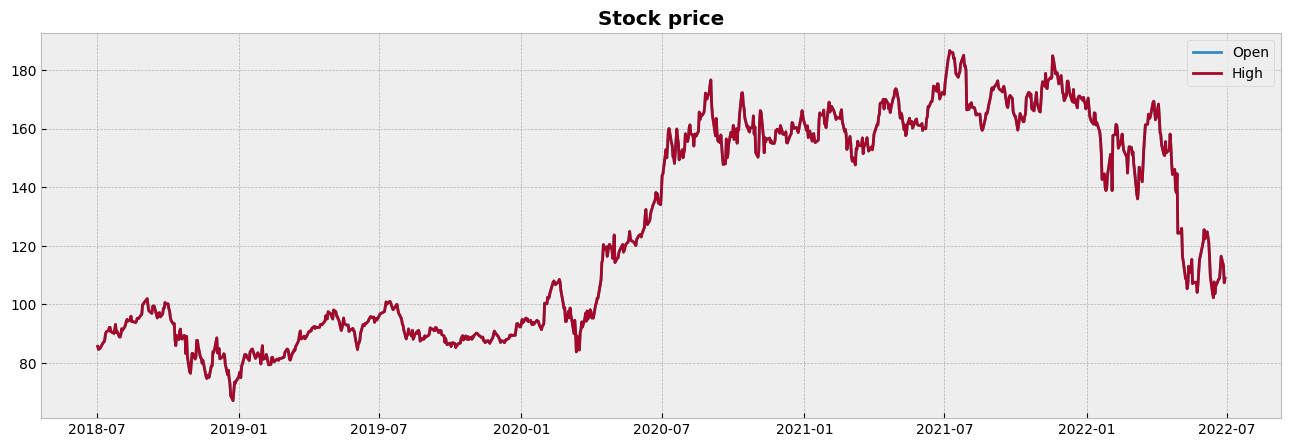

In [12]:
plot_fields =  ['Close', 'Adj Close']

fig = plt.figure(figsize=(16, 5))

plt.plot(Amazon_data[plot_fields])
plt.legend(Amazon_data)

plt.title("Stock price", weight="bold")

plt.show()

### Предобработка данных и построение графика доходностей

In [106]:
#print(Amazon_data.index)
Amazon_data.index = Amazon_data.index.to_period(freq='d') # устанавливаем частотность в 1 день
#print(Amazon_data.index)

# цены
price = Amazon_data['Adj Close']
#price.head()

# процентное изменение
ret = price.pct_change() 
#ret.head()

# удаление строк с пустыми значениями
ret.dropna(inplace=True) 

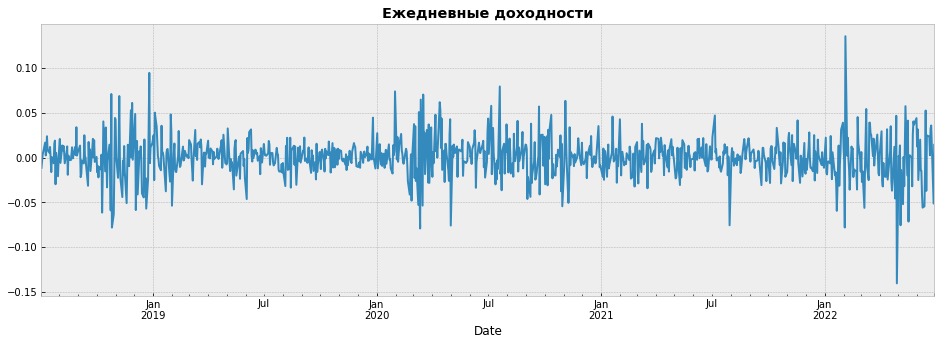

In [107]:
fig = plt.figure(figsize=(16, 5))

ret.plot()
plt.title("Ежедневные доходности", weight="bold")

plt.show()

### Моделирование VaR

In [108]:
# вычисление VaR

def calc_VaR(r, VaR_fun, L_history=252, level=0.05):
    VaR = np.full(r.size, np.nan)
    
    for i in range(L_history, len(r)):
        history = r[i - L_history: i]
        VaR[i] = VaR_fun(history, level)
        
    return pd.Series(data=VaR, index=r.index, name=VaR_fun.__name__)

### Garch

In [110]:
# для Garch модели

def calculate_VaR_garch(returns, alpha):
    
    scaling_const = 10.0 / returns.std()

    dist = 't'
    am = arch_model(scaling_const * returns,
                    mean='Constant', lags=1, 
                    vol='FIGARCH', p=1, q=1, power=2, 
                    dist=dist) 

    res = am.fit(update_freq=0, disp='off')

    forecasts = res.forecast(horizon=1)

    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])


    if dist == 't' or dist == 'ged':
        q = am.distribution.ppf(alpha, res.params[-1:])
    elif dist == 'skewstudent':
        q = am.distribution.ppf(alpha, res.params[-2:])

    return_garch_forecast = cond_mean / scaling_const
    VaR_garch_forecast = (cond_mean + np.sqrt(cond_var) * q) / scaling_const

    return VaR_garch_forecast

### Обратное Гауссовское распределение

In [111]:
norminv_params = norminvgauss.fit(ret)

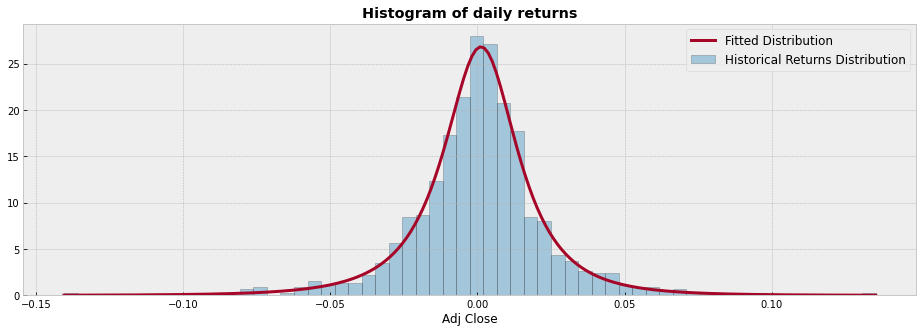

In [112]:
fig = plt.figure(figsize=(16, 5))

x = np.linspace(ret.min(), ret.max(), 200)

y_pdf = norminvgauss.pdf(x, *norminv_params)

sns.distplot(ret, hist=True, kde=False, 
             bins=60, norm_hist=True,
             hist_kws={'edgecolor':'black'})
plt.plot(x, y_pdf, linewidth=3)

plt.title("Histogram of daily returns", weight="bold")
plt.legend(['Fitted Distribution', 'Historical Returns Distribution'], fontsize=12)


plt.show()

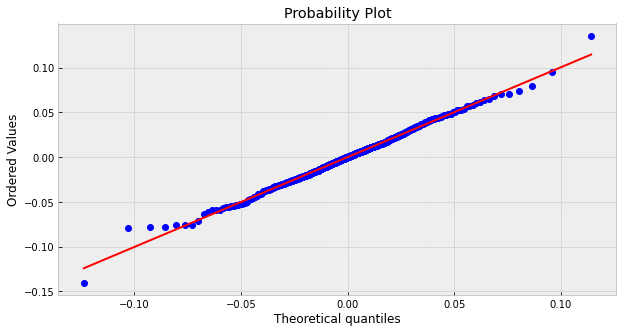

In [113]:
fig = plt.figure(figsize=(10, 5))
ss.probplot(ret, dist=norminvgauss(*norminv_params), plot=plt)
plt.show()

In [114]:
def calculate_VaR_norminv(ret, alpha=0.05):
    norminv_params = norminvgauss.fit(ret)
    params_norm = ss.norm.fit(ret)
    
    return norminvgauss.ppf(alpha, *norminv_params)

### Комбинация Garch и EVT

In [115]:
# Excess Distribution Over a Threshold

def calculate_VaR_pot(ret, alpha=0.05):
    
    u = ret.quantile(0.2)
    ret_tail = ret[ret <= u]

    c, loc, scale = ss.genpareto.fit(-ret_tail, loc=0)
    
    return u - scale / c * ((alpha/(ret <= u).mean())**(-c) - 1)

In [116]:
def calculate_VaR_EVT(returns, alpha):
    
    scaling_const = 10.0 / returns.std()

    mdl = arch_model(scaling_const * returns,
                    mean='HARX', lags=1, 
                    vol='Garch', p=1, o=1, q=1, 
                    dist='normal')

    res = mdl.fit(disp='off')

   # получаем стандартизированные остатки
    stand_residuals = res.resid / res.conditional_volatility
    stand_residuals = stand_residuals.dropna()

   # предсказываем среднее и десперсию на один шаг вперед
    forecasts = res.forecast(horizon=1)
    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    # получаем предсказанные условные доходности
    conditional_sr = cond_mean + np.sqrt(cond_var) * stand_residuals
    conditional_sr = conditional_sr / scaling_const

    # считаем VaR 
    VaR_FHS = calculate_VaR_pot(conditional_sr, alpha=0.05)

    return VaR_FHS

### Расчеты

In [117]:
VaR_garch = calc_VaR(ret, calculate_VaR_garch, L_history=252, level=alpha)
VaR_norminv = calc_VaR(ret, calculate_VaR_norminv, L_history=252, level=alpha)
VaR_garch_evt = calc_VaR(ret, calculate_VaR_EVT, L_history=252, level=alpha)

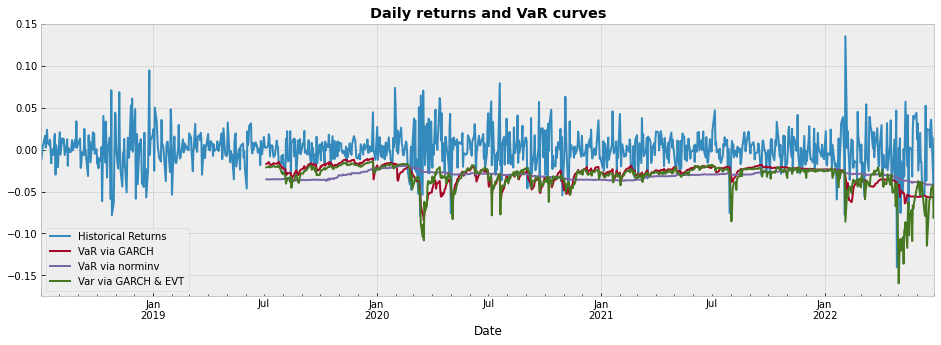

In [118]:
fig = plt.figure(figsize=(16, 5))

ret.plot()
VaR_garch.plot()
VaR_norminv.plot()
VaR_garch_evt.plot()

plt.title("Daily returns and VaR curves", weight="bold")
plt.legend(['Historical Returns', 'VaR via GARCH', 'VaR via norminv', 'Var via GARCH & EVT'])

plt.show()

### Бэктестирование 

In [119]:
def calc_hits(returns, VaRs):
    return ((VaRs - returns).dropna() > 0).values

In [120]:
def zone(p):
    if p > 0.05:
        return 'green'
    elif p > 0.0001:
        return 'yellow'
    else:
        return 'red'

In [121]:
def backtest_VaR(r, VaR, level, L=None):
    if L is None:
        L = (~VaR.isna()).to_numpy().nonzero()[0][0];
    r = r[L:]
    VaR = VaR[L:]
    hits = calc_hits(r, VaR)    
    
    p_value_two_sided = ss.binom_test(sum(hits), len(hits), 1-level, alternative = 'two-sided')
    p_value_conservative = ss.binom_test(sum(hits), len(hits), 1-level, alternative = 'greater')
    print(f'Backtesting {VaR.name}:')
    print(f'The proportion of hits is {(sum(hits)/len(hits))*100:.3}% instead of expected {(1-level)*100:.3}%')
    print(f'Two-sided p-val {p_value_two_sided:.3}, one-sided: {p_value_conservative:.3}')
    print(f'{zone(p_value_two_sided)} zone\n')

In [122]:
backtest_VaR(ret, VaR_garch, 1-alpha)
backtest_VaR(ret, VaR_norminv, 1-alpha)
backtest_VaR(ret, VaR_garch_evt, 1-alpha)

Backtesting calculate_VaR_garch:
The proportion of hits is 6.77% instead of expected 5.0%
Two-sided p-val 0.0295, one-sided: 0.0192
yellow zone

Backtesting calculate_VaR_norminv:
The proportion of hits is 6.51% instead of expected 5.0%
Two-sided p-val 0.0652, one-sided: 0.0388
green zone

Backtesting calculate_VaR_EVT:
The proportion of hits is 5.58% instead of expected 5.0%
Two-sided p-val 0.451, one-sided: 0.255
green zone



### Выводы

Односторонний биномиальный тест:

H_0: ожидаемая доля пробоев <= уровня значимости (5%)

H_1: ожидаемая доля пробоев > уровня значимости (5%)

Двусторонний биномиальный тест:

H_0: ожидаемая доля пробоев = уровня значимости (5%)

H_1: ожидаемая доля пробоев != уровню значимости (5%)

Видим, что значения p-value (и one-sided и two-sided) для модели Garch+EVT наибольшие => такой подход является наиболее подходящим в рассматриваемом случае.
